# Agent 5 (EOA): Autonomous Event Planner Workshop
**Objective:** Build an AI Agent using the **ReAct Pattern** (Reasoning + Acting) that can autonomously organize events, handle overlapping schedules, and recover from errors.

**Tech Stack:**
* Framework: LangChain & LangGraph
* Model: Google Gemini 2.5 Flash Lite
* Pattern: State Machine (StateGraph)

In [3]:
# Setup & Dependencies

# Install dependencies if running in Colab/Fresh Environment
# %pip install langchain langgraph langchain-google-genai pydantic-settings python-dotenv

In [ ]:
import os
import getpass
from dotenv import load_dotenv

# Load API Key from .env file
load_dotenv()

# Or prompt for it interactively (Secure for workshops)
if not os.environ.get("GOOGLE_API_KEY"):
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter Google API Key: ")

## Part 1: The "Hands" (Mock Tools)
The agent needs to connect to a **Calendar** and an **Email** system. We will mock these systems to simulate real-world constraints (like busy slots or maintenance errors).

In [18]:
# Defining Tools

import random
import logging
from langchain_core.tools import tool

# Setup Logging to see the "Actions"
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("tools")

# --- 1. MOCK DATABASE ---
# This dictionary acts as our persistent storage
calendar_db = {
    "2023-10-20": ["10:00", "11:00"], # Busy slots
    "2023-10-21": [], # Free day
    "2023-10-22": []
}

# --- 2. TOOL DEFINITIONS ---
@tool
def check_calendar_availability(date: str) -> str:
    """
    Checks if a specific date is available. 
    Returns a list of busy slots or a confirmation that it's free.
    """
    logger.info(f"📅 Checking calendar for {date}.c..")
    
    if date in calendar_db:
        busy_slots = calendar_db[date]
        if not busy_slots:
            return f"Date {date} is completely free."
        else:
            return f"Date {date} has busy slots at: {', '.join(busy_slots)}."
    return f"Date {date} is completely free."

@tool
def book_venue(date: str, time: str) -> str:
    """
    Books the venue for a specific date and time.
    """
    logger.info(f"📝 Attempting to book venue on {date} at {time}...")
    
    # --- SIMULATED FAILURE (Test Case: Resilience) ---
    # 20% chance of random failure to test if Agent can 'Recover'
    if random.random() < 0.2: 
        return "Error: Venue is unexpectedly under maintenance. Booking failed."
    
    # Check logic
    if date in calendar_db and time in calendar_db[date]:
        return f"Error: Slot {time} on {date} is already booked."
    
    # Success logic
    if date not in calendar_db:
        calendar_db[date] = []
    calendar_db[date].append(time)
    
    return f"Success: Venue booked for {date} at {time}."

@tool
def send_email_invitation(recipient_list: str, subject: str) -> str:
    """
    Sends email invitations to a list of recipients.
    """
    logger.info(f"📧 Sending emails to {recipient_list}...")
    return f"Success: Sent {len(recipient_list.split(','))} invitations."

In [5]:
# List of tools to bind to the LLM
tools = [check_calendar_availability, book_venue, send_email_invitation]

## Part 2: The "Brain" (State Machine)
We use **LangGraph** to define the workflow. This fulfills the requirement for using a **State Machine** to control the agent's logic.

* **Planner Node:** The LLM thinks about the next step.
* **Router:** Decides whether to use a tool or finish.
* **State:** Keeps track of the chat history.

In [22]:
# Agent Logic

import operator
from typing import Annotated, List, TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import BaseMessage, SystemMessage
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

# 1. DEFINE STATE
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]

# 2. SETUP MODEL
# Ensure you are using a model capable of tool calling
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite", temperature=0)
llm_with_tools = llm.bind_tools(tools)

# 3. DEFINE NODES
def planner_node(state: AgentState):
    """The Reasoning Engine"""
    # System Prompt enforces the 'Error Recovery' behavior
    system_prompt = SystemMessage(content="""
    You are the Autonomous Event Planner (Agent 5).
    GOAL: Organize events by checking availability, booking venues, and sending invites.
    
    CRITICAL RULES:
    1. ALWAYS check availability (check_calendar_availability) before booking.
    2. If a booking fails (Error or Busy), DO NOT GIVE UP. Propose/Try/Suggest the next available time slot.
    3. Only end when the venue is booked and emails are sent.
    """)
    
    messages = [system_prompt] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: AgentState) -> str:
    """The Router Logic"""
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"
    return "end"

# 4. BUILD GRAPH
workflow = StateGraph(AgentState)

workflow.add_node("planner", planner_node)
workflow.add_node("tools", ToolNode(tools)) # Prebuilt node to run our @tool functions

workflow.set_entry_point("planner")

workflow.add_conditional_edges(
    "planner",
    should_continue,
    {
        "tools": "tools",
        "end": END
    }
)

workflow.add_edge("tools", "planner") # Loop back to observe result

app = workflow.compile()

## Part 3: Visualization (Workflow Traces)
The project deliverables require **"Workflow Traces"** to show how the AI decides. LangGraph allows us to visualize this logic as a diagram.

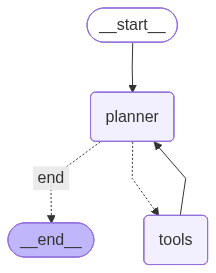

In [ ]:
# Visualizing the workflow graph

from IPython.display import Image, display

# Visualize the State Machine
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # Requires backend dependencies like graphviz
    print("Graph visualization skipped (dependency missing).")

## Part 4: Testing Scenarios
We will now run the **Test Cases** to verify the "Schedule Conflict" requirement.

**Scenario:** User requests a slot we know is busy (`2023-10-20` at `10:00`).

**Expected:** Agent should detect the busy slot and automatically switch to the afternoon.

In [23]:
# Running the Test

from langchain_core.messages import HumanMessage

def run_test_case(case_name, prompt):
    print(f"\n🚀 TEST CASE: {case_name}")
    print(f"📝 Prompt: {prompt}")
    print("="*180)
    
    inputs = {"messages": [HumanMessage(content=prompt)]}
    
    for output in app.stream(inputs):
        for key, value in output.items():
            last_msg = value["messages"][-1]
            if key == "planner":
                if last_msg.tool_calls:
                     print(f"🤖 PLANNER: Decided to call -> {last_msg.tool_calls[0]['name']}")
                else:
                     print(f"🤖 PLANNER: Final Response -> {last_msg.content}")
            elif key == "tools":
                 # Tool output is already logged by our logger, but we print here for clarity
                 pass 
    print("="*60)

# --- SCENARIO 1: Schedule Conflict (ตารางทับซ้อน) ---
# We force it to hit the busy slot at 10:00 on Oct 20th.
run_test_case(
    "Schedule Conflict Test",
    "I need to book 'Workshop 9' on 2023-10-20 at 10:00. "
    "If busy, find the next available slot in the afternoon."
)

# --- SCENARIO 2: Notification / Hybrid Event (แจ้งเตือน) ---
# We use a free date (Oct 21) to ensure the 'Happy Path' works and invites are sent.
run_test_case(
    "Hybrid Event Notification Test",
    "Set up a 'Hybrid Workshop' on 2023-10-21 at 09:00. "
    "Send an email invitation to 'student@tu.ac.th' with the subject 'Hybrid Meeting Link'."
)


🚀 TEST CASE: Schedule Conflict Test
📝 Prompt: I need to book 'Workshop 9' on 2023-10-20 at 10:00. If busy, find the next available slot in the afternoon.


INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
INFO:tools:📅 Checking calendar for 2023-10-20...


🤖 PLANNER: Decided to call -> check_calendar_availability


INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
INFO:tools:📝 Attempting to book venue on 2023-10-20 at 10:00...


🤖 PLANNER: Decided to call -> book_venue


INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
INFO:tools:📝 Attempting to book venue on 2023-10-20 at 14:00...


🤖 PLANNER: Decided to call -> book_venue


INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
INFO:tools:📝 Attempting to book venue on 2023-10-20 at 15:00...


🤖 PLANNER: Decided to call -> book_venue


INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"


🤖 PLANNER: Final Response -> The venue is booked for 2023-10-20 at 15:00. Who should I send the email invitations to?

🚀 TEST CASE: Hybrid Event Notification Test
📝 Prompt: Set up a 'Hybrid Workshop' on 2023-10-21 at 09:00. Send an email invitation to 'student@tu.ac.th' with the subject 'Hybrid Meeting Link'.


INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
INFO:tools:📅 Checking calendar for 2023-10-21...


🤖 PLANNER: Decided to call -> check_calendar_availability


INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
INFO:tools:📝 Attempting to book venue on 2023-10-21 at 09:00...


🤖 PLANNER: Decided to call -> book_venue


INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
INFO:tools:📧 Sending emails to student@tu.ac.th...


🤖 PLANNER: Decided to call -> send_email_invitation


INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"


🤖 PLANNER: Final Response -> The event 'Hybrid Workshop' has been set up for 2023-10-21 at 09:00 and the invitation has been sent to 'student@tu.ac.th'.


## Conclusion
This notebook demonstrates the **ReAct Pattern** required for **Agent 5: Event Orchestration Agent (EOA)**.

The agent successfully:
1. **Reasoned** about the user's request.
2. **Acted** by checking the calendar.
3. **Observed** a conflict (busy slot).
4. **Adapted** by booking a new time slot automatically.